# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 9

**Issued**: Tuesday, June 25, 2024, 1:00 pm

**Due**: Tuesday, July 2, 2024, 1:00 pm

# Computational Tomography with Un-trained Neural Networks

In this exercise, the task is to reconstruct an image in the context of computational tomography. The original images is given as $x$ below, and is loaded from the the file original.npy, which must be in the same folder as this notebook.

Below, you are given the measurement operator $A$ and a measurement obtained as
$$
y = A x.
$$
The task is to reconstruct the image $x$ from $y$ with an un-trained neural network. You are welcome to use code from any repository of your choice, for example:
- Deep image prior: [https://github.com/DmitryUlyanov/deep-image-prior](https://github.com/DmitryUlyanov/deep-image-prior)
- Deep decoder: [https://github.com/reinhardh/supplement_deep_decoder](https://github.com/reinhardh/supplement_deep_decoder)
- Compressive sensing with the deep decoder [https://github.com/MLI-lab/cs_deep_decoder](https://github.com/MLI-lab/cs_deep_decoder)

To make this work, you might have to tune the network and optimization appropriately.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
from PIL import Image

import numbers
# import pywt
import scipy
import skimage.color as color
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
# from skimage.measure import compare_psnr
import os
from PIL import Image
import PIL
import h5py
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.optim
from torch.autograd import Variable

In [2]:
filepath = "original.npy"
device = "cuda:0" # or 'cpu'
# device = 'cpu'

In [3]:
# use_colab = "colab" in str(get_ipython())
# if use_colab:
#   from google.colab import drive
#   drive.mount('/content/drive')
#   # base_folder might need to be adapted, depending on where
#   base_folder = '/content/drive/MyDrive/Colab Notebooks'
#   filepath = f'{base_folder}/{filepath}'

In [4]:
# load ground truth
# x=torch.FloatTensor(np.load(filepath), device=device)
x=torch.FloatTensor(np.load(filepath)).to(device)

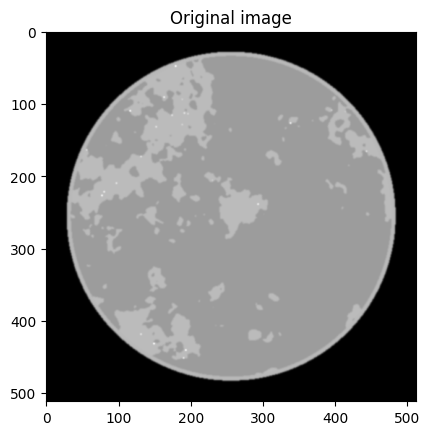

In [5]:
#Plot original image

plt.imshow(x.to('cpu'))
plt.gray()
plt.title('Original image')
plt.show()

In the following we define the forward model $A$, which represents a parallel beam projection (also known as a discrete radon transform) with a 4x acceleration factor.

In [6]:
#Forward Model A

def A(image):
    n=image.shape[0]
    m=n//4  # 4 times acceleration
    pbp = torch.zeros(m,n)
    image=image.unsqueeze(0)
    
    for i in range(m):
        proj = F.rotate(image, -i*180/m).squeeze(0)
        pbp[i,:] = torch.sum(proj,0)
        
    return pbp

The measurement, $y$, is created by: $y=A(x)$

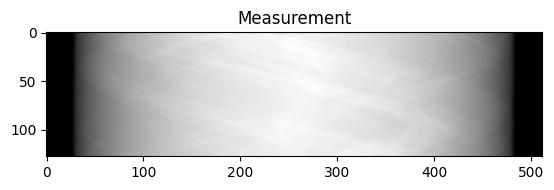

In [7]:
#create and plot measurement
y=A(x.to('cpu'))

plt.imshow(y)
plt.title('Measurement')
plt.show()

## Task: Reconstruct the image using an untrained-method
Hint: Copy and adapt the code from one of the repositories (network architecture, fitting, hyperparameter settings etc.)

In [14]:
from unet import Unet
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm import tqdm

# create a U-Net
net = Unet(in_chans=1, out_chans=1)
input = torch.rand(1, 1, x.shape[0], x.shape[1])
loss = MSELoss()
optimizer = Adam(net.parameters(), lr=0.001)

In [21]:
for i in tqdm(range(50)):
    optimizer.zero_grad()
    output = net(input).squeeze(0).squeeze(0)
    loss_val = loss(A(output), y)
    loss_val.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss: {loss_val.item()}')

  2%|▏         | 1/50 [00:06<05:39,  6.94s/it]

Loss: 32.36531448364258


100%|██████████| 50/50 [12:55<00:00, 15.51s/it]


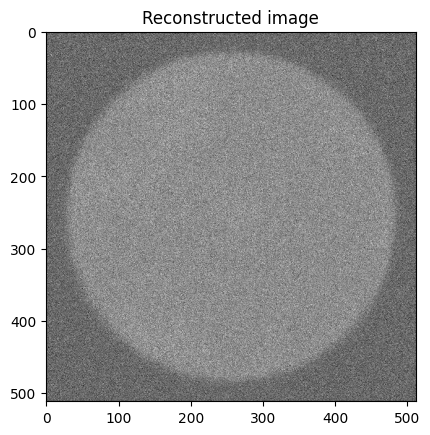

In [22]:
x_hat = net(input).squeeze(0).squeeze(0)
#Plot original image

plt.imshow(x_hat.detach().numpy())
plt.gray()
plt.title('Reconstructed image')
plt.show()